# **1. Create a neural network that performs dimensionality reduction using PCA and then reconstructs the input data, considering that**

$X\in \mathbb{R}^{N\times P}$ and the network $\hat{X}=(f_1 \circ f_0)(X)$ must satisfy that it has weights $W_0$ and $W_1$ in the first and second layers respectively, and it must satisfy that $W_0=W_1^T$.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, losses, Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

2024-02-27 15:52:22.514141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 15:52:22.514288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 15:52:22.692605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


For this exercise, I am going to use the MNIST dataset.

In [2]:
# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
scale = 0.4
x_train = x_train.astype('float32') / 255. + np.random.normal(scale=scale,size=x_train.shape)
x_test = x_test.astype('float32') / 255. + np.random.normal(scale=scale,size=x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.reshape((x_train.shape[0], 28*28))
x_test = x_test.reshape((x_test.shape[0], 28*28))

x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

To impose the restriction that $W_1 = W_0^T$, I propose creating a new class to customize the second layer of my neural network.

In [4]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z)

In [5]:
input_dim = 784  # MNIST
encoding_dim = 46  # dimensionality reduction

# Input layer
input_layer = Input(shape=(input_dim,))
f0 = Dense(encoding_dim, activation='linear')
f0_tensor  = f0(input_layer)

# Output layer
f1 = DenseTranspose(f0, activation='linear')
f1_tensor = f1(f0_tensor)

# Model
model = Model(inputs=input_layer, outputs=f1_tensor)

In [6]:
model.compile(optimizer='adam', loss='mean_squared_error')

# datos_x serían tus datos de entrenamiento
model.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_val, x_val))

Epoch 1/20
196/196 [==============================] - 2s 8ms/step - loss: 0.1923 - val_loss: 0.1743
Epoch 2/20
196/196 [==============================] - 1s 6ms/step - loss: 0.1705 - val_loss: 0.1677
Epoch 3/20
196/196 [==============================] - 1s 6ms/step - loss: 0.1665 - val_loss: 0.1655
Epoch 4/20
196/196 [==============================] - 1s 6ms/step - loss: 0.1650 - val_loss: 0.1646
Epoch 5/20
196/196 [==============================] - 1s 6ms/step - loss: 0.1644 - val_loss: 0.1642
Epoch 6/20
196/196 [==============================] - 1s 6ms/step - loss: 0.1642 - val_loss: 0.1641
Epoch 7/20
196/196 [==============================] - 1s 7ms/step - loss: 0.1641 - val_loss: 0.1640
Epoch 8/20
196/196 [==============================] - 1s 6ms/step - loss: 0.1640 - val_loss: 0.1640
Epoch 9/20
196/196 [==============================] - 1s 6ms/step - loss: 0.1640 - val_loss: 0.1639
Epoch 10/20
196/196 [==============================] - 1s 6ms/step - loss: 0.1640 - val_loss: 0.1639

Now, I am interested in knowing how similar my input is to the newly reconstructed dataset.

In [7]:
x_pca = model.predict(x_test)
mse = mean_squared_error(x_test, x_pca)
print(r"The mean square error between $X$ and $\hat{X}$ is: %s" % mse)

313/313 [==============================] - 1s 2ms/step
The mean square error between $X$ and $\hat{X}$ is: 0.1637760870769123


On the other hand, let's take a look at some elements of our input and their reconstructed form.

In [8]:
def plot_mnist_autoencoder(x, x_, y=None, y_=None, cmap='gray', vmin=0, vmax=1):
    plt.figure(figsize=(20, 2))
    for i, (train, predict) in enumerate(zip(x, x_), start=1):
        plt.subplot(2, len(x), i)
        plt.imshow(train.reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        plt.axis('off')
        
        plt.subplot(2, len(x), i+len(x))
        plt.axis('off')
        plt.imshow(predict.reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)

        if y is not None:
            color = ["red", 'green'][bool(y[i-1] == y_[i-1])]
            plt.text(0, 28, str(y_[i-1]), color=color, fontsize=15, verticalalignment='bottom', horizontalalignment='left')

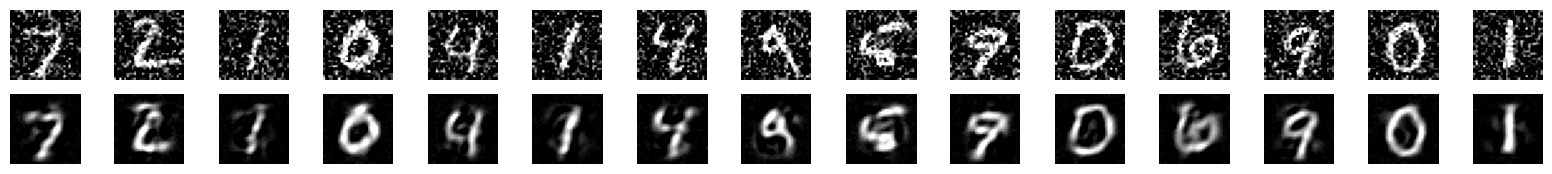

In [9]:
plot_mnist_autoencoder(x_test[0:15],x_pca[0:15])

# **2. The second exercise is to add another output, which consists of the labels of the input data (in our case, indicating which number belongs to each image).**

I propose creating a "parallel layer" that receives only the reduced data and classifies the input, serving as the second output of my model.

In [10]:
# Parallel layer
f2 = Dense(10, activation='softmax')
f2_tensor = f2(f0_tensor)

# Model
model2 = Model(inputs=input_layer, outputs=[f1_tensor, f2_tensor])

In [11]:
model2.compile(optimizer='adam', loss=['mean_squared_error', 'categorical_crossentropy'], loss_weights = [1,5])

# datos_x serían tus datos de entrenamiento
model2.fit(x_train, [x_train, y_train], epochs=50, batch_size=256, shuffle=True, validation_data=(x_val, [x_val, y_val]))

Epoch 1/50
196/196 [==============================] - 2s 8ms/step - loss: 4.6789 - dense_transpose_loss: 0.2406 - dense_1_loss: 0.8877 - val_loss: 2.6063 - val_dense_transpose_loss: 0.2780 - val_dense_1_loss: 0.4657
Epoch 2/50
196/196 [==============================] - 1s 6ms/step - loss: 2.6255 - dense_transpose_loss: 0.2813 - dense_1_loss: 0.4688 - val_loss: 2.4436 - val_dense_transpose_loss: 0.2773 - val_dense_1_loss: 0.4333
Epoch 3/50
196/196 [==============================] - 1s 6ms/step - loss: 2.4618 - dense_transpose_loss: 0.2775 - dense_1_loss: 0.4369 - val_loss: 2.4051 - val_dense_transpose_loss: 0.2726 - val_dense_1_loss: 0.4265
Epoch 4/50
196/196 [==============================] - 1s 6ms/step - loss: 2.3944 - dense_transpose_loss: 0.2710 - dense_1_loss: 0.4247 - val_loss: 2.4175 - val_dense_transpose_loss: 0.2655 - val_dense_1_loss: 0.4304
Epoch 5/50
196/196 [==============================] - 1s 6ms/step - loss: 2.3657 - dense_transpose_loss: 0.2667 - dense_1_loss: 0.4198 -

In [12]:
x_pca2, y_pred = model2.predict(x_test)
mse_x = mean_squared_error(x_test, x_pca2)
print(r"The mean square error between $X$ and $\hat{X}$ is: %s" % mse_x)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

313/313 [==============================] - 1s 2ms/step
The mean square error between $X$ and $\hat{X}$ is: 0.21450679610356752
Accuracy: 0.8592


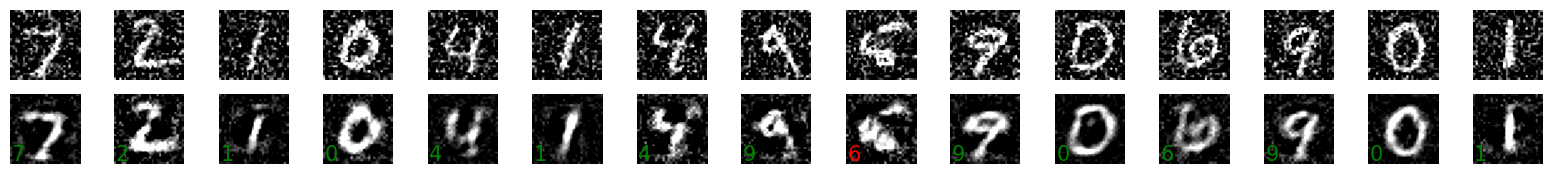

In [13]:
plot_mnist_autoencoder(x_test[0:15],x_pca2[0:15], y_test[0:15], y_pred[0:15])